In [1]:
# This notebook is optimized to run on a gpu instance of Amazon Sagemaker.

In [2]:
# imports

# All of these modules are either included in the code base
# or provided by default on Amazon Sagemaker. 

import gc
import glob
import json
import math
import os
import pickle
import pprint
import random
import time
from collections import Counter
from pathlib import Path
from time import gmtime, strftime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from db import NABat_DB
from PIL import Image
from tensorflow import keras
from keras import layers
from keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model


In [3]:
import db_handler
import dataset_generator as ds

In [4]:
db = NABat_DB(p="db0")
# Get available information for species.
species = db.query('select species_code from species;')
sample_classes = ds.get_sample_classes('../Downloads/data/wav')

In [5]:
species_codes = []
for i in species:
    species_codes += [i.species_code]

In [6]:
wav_directory = '../Downloads/data/images'
species_files = []
file_counts = []
pulse_counts = []
x = [c.split('/')[-1] for c in glob.glob('{}/*'.format(wav_directory), recursive=True)]

for c in x:
    if c in species_codes:
        file_count = len(glob.glob('{}/{}/*'.format(wav_directory, c), recursive=True))
        pulse_count = len(glob.glob('{}/{}/**/*'.format(wav_directory, c), recursive=True)) - file_count
        pulse_counts.append(pulse_count)
        file_counts.append(file_count)
        species_files.append(c)
        
species_files

['LABO',
 'NYFE',
 'TABR',
 'MYAU',
 'MYYU',
 'COTO',
 'MYSO',
 'PESU',
 'MYVE',
 'MYTH',
 'ANPA',
 'NYMA',
 'MYLU',
 'MYGR',
 'LABL',
 'LANO',
 'PAHE',
 'CORA',
 'NOISE',
 'LASE',
 'EUPE',
 'EPFU',
 'MYVO',
 'MYSE',
 'IDPH',
 'LAXA',
 'EUFL',
 'LACI',
 'MYCA',
 'MYLE',
 'LAIN',
 'MYEV',
 'NYHU',
 'MYCI']

In [7]:
# Print tensorflow version and whether we have access to a gpu.
print(tf.__version__)
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set the random seed for repeatability.
seed = 546
random.seed(seed)

# Create a place to store our trained models.
try:
    os.mkdir('models')
except:
    pass

2.10.0
Number of GPUs Available:  0


In [8]:
# Test the image generator function.
gen_validate = ds.image_generator('validate')
validate_samples_dict = dict()
for item in gen_validate:
    image_metadata = item
    key = sample_classes[image_metadata[1]]
    if validate_samples_dict.__contains__(key):
        validate_samples_dict[key] = validate_samples_dict.get(key) + 1
    else:
        validate_samples_dict[key] = 1

validate_samples_dict

{'LABO': 3766,
 'TABR': 2032,
 'MYAU': 748,
 'MYYU': 3130,
 'COTO': 909,
 'MYSO': 2694,
 'PESU': 3787,
 'MYTH': 3603,
 'ANPA': 654,
 'NYMA': 292,
 'MYLU': 4416,
 'MYGR': 1165,
 'LABL': 417,
 'LANO': 2375,
 'PAHE': 2898,
 'NOISE': 257,
 'LASE': 2115,
 'EUPE': 183,
 'EPFU': 4459,
 'MYVO': 2556,
 'MYSE': 1798,
 'IDPH': 163,
 'LACI': 1916,
 'MYCA': 3796,
 'MYLE': 1815,
 'LAIN': 1790,
 'MYEV': 3510,
 'NYHU': 4528,
 'MYCI': 4687}

In [9]:
gen_test = ds.image_generator('test')
test_samples_dict = dict()
for item in gen_test:
    image_metadata = item
    key = sample_classes[image_metadata[1]]
    if test_samples_dict.__contains__(key):
        test_samples_dict[key] = test_samples_dict.get(key) + 1
    else:
        test_samples_dict[key] = 1

test_samples_dict

{'LABO': 3747,
 'TABR': 1802,
 'MYAU': 381,
 'MYYU': 2844,
 'COTO': 597,
 'MYSO': 2813,
 'PESU': 3680,
 'MYTH': 3807,
 'ANPA': 1202,
 'NYMA': 274,
 'MYLU': 3444,
 'MYGR': 1029,
 'LABL': 609,
 'LANO': 2087,
 'PAHE': 3387,
 'NOISE': 141,
 'LASE': 2365,
 'EUPE': 135,
 'EPFU': 4868,
 'MYVO': 2469,
 'MYSE': 1206,
 'IDPH': 262,
 'LACI': 1825,
 'MYCA': 4194,
 'MYLE': 2779,
 'LAIN': 3039,
 'MYEV': 3328,
 'NYHU': 5036,
 'MYCI': 5179}

In [10]:
gen_train = ds.image_generator('train')
train_samples_dict = dict()
for item in gen_train:
    image_metadata = item
    key = sample_classes[image_metadata[1]]
    if train_samples_dict.__contains__(key):
        train_samples_dict[key] = train_samples_dict.get(key) + 1
    else:
        train_samples_dict[key] = 1

train_samples_dict

{'LABO': 30101,
 'TABR': 14777,
 'MYAU': 4783,
 'MYYU': 25024,
 'COTO': 4102,
 'MYSO': 22786,
 'PESU': 29191,
 'MYTH': 26861,
 'ANPA': 5954,
 'NYMA': 1647,
 'MYLU': 29945,
 'MYGR': 8116,
 'LABL': 2729,
 'LANO': 17761,
 'PAHE': 25414,
 'NOISE': 1871,
 'LASE': 17926,
 'EUPE': 2795,
 'EPFU': 30557,
 'MYVO': 23075,
 'MYSE': 11337,
 'IDPH': 1307,
 'LACI': 13980,
 'MYCA': 29820,
 'MYLE': 18915,
 'LAIN': 20576,
 'MYEV': 29347,
 'NYHU': 37526,
 'MYCI': 38092}

In [11]:
samples = pd.DataFrame()
samples['Species'] = validate_samples_dict.keys()
samples['Pulses for validation'] = validate_samples_dict.values()
samples['Pulses for testing'] = test_samples_dict.values()
samples['Pulses for training'] = train_samples_dict.values()
samples = samples.set_index('Species')
samples = samples.reindex(species_files, fill_value=0)
samples["Pulse counts"] = pulse_counts
samples["File counts"] = file_counts

In [12]:
samples.to_csv('20230811_model_dataset_info.csv')

In [13]:
# Define the batch size for the network.
batch_size = 32

# Create a training dataset.
train_dataset = tf.data.Dataset.from_generator(
    ds.image_generator, args=['train'],
    output_types=({"input_1": tf.float16}, tf.int32),
    output_shapes=({"input_1": (100,100,3)}, () )                                      
    ).batch(batch_size).prefetch(1000)

# Create a validation dataset.
validation_dataset = tf.data.Dataset.from_generator(
    ds.image_generator, args=['validate'],
    output_types=({"input_1": tf.float16}, tf.int32),
    output_shapes=({"input_1": (100,100,3)}, () )                                      
    ).batch(batch_size).prefetch(1000)


In [15]:

# Save the metadata for the current model run.
with open('models/training_history_{}.p'.format('0'), 'wb') as fp:

    # Define model inputs.
    inputs = layers.Input(shape=(100,100,3))

    # Define network shape.
    w = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    w = layers.Dropout(0.2)(w)
    w = layers.MaxPooling2D(padding='same')(w)
    w = layers.Conv2D(64, 3, activation='relu', padding='same')(w)
    w = layers.Conv2D(64, 3, activation='relu', padding='same')(w)
    w = layers.Dropout(0.2)(w)
    w = layers.MaxPooling2D(padding='same')(w)
    w = layers.Conv2D(128, 3, activation='relu', padding='same')(w)
    w = layers.Conv2D(128, 3, activation='relu', padding='same')(w)
    w = layers.Conv2D(128, 3, activation='relu', padding='same')(w)
    w = layers.Dropout(0.2)(w)
    w = layers.MaxPooling2D(padding='same')(w)
    w = layers.Flatten()(w)
    w = layers.Dropout(0.4)(w)
    w = layers.Dense(256, activation='relu')(w)
    w = layers.Dropout(0.4)(w)
    w = layers.Dense(256, activation='relu')(w)
    w = layers.Dropout(0.4)(w)
    w = layers.Dense(256, activation="relu")(w)
    w = layers.Dense(len(sample_classes), activation="softmax")(w)
   
    model = Model(inputs=inputs, outputs=w)
    
    # Print and plot network.
    model.summary()
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    # Set the hyperparameters for this model run.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9,
                                        beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                        name='Adam'
                                        ),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy']
        )

    # Define the early stopping criteria.
    print("Define the early stopping criteria.")
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

    # Start the training. This will produce a preliminary (course) model.
    print("Start the training. This will produce a preliminary (course) model.")
    h = model.fit(train_dataset,
                validation_data=validation_dataset,
                epochs=25,
                verbose=1,
                callbacks=[es]
        )

    # Save the metadata, model, and weights to disk.
    print("Save the metadata, model, and weights to disk.")
    model.save('models/m-{}'.format('0'))
    pickle.dump((h.history, sample_classes), fp)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        36928     
                                                             

2023-08-10 00:19:59.017661: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16448/16448 [==============================] - 7893s 480ms/step - loss: 0.5298 - accuracy: 0.9191 - val_loss: 16.7475 - val_accuracy: 0.0567
Epoch 2/25
16448/16448 [==============================] - 7607s 462ms/step - loss: 0.4064 - accuracy: 0.9058 - val_loss: 10.0948 - val_accuracy: 0.0567
Epoch 3/25
16448/16448 [==============================] - 7347s 447ms/step - loss: 0.7571 - accuracy: 0.8020 - val_loss: 8.8679 - val_accuracy: 0.0567
Epoch 4/25
16448/16448 [==============================] - 7185s 437ms/step - loss: 2.4407 - accuracy: 0.2576 - val_loss: 3.3889 - val_accuracy: 0.0705
Epoch 5/25
16448/16448 [==============================] - 6907s 420ms/step - loss: 3.4314 - accuracy: 0.0207 - val_loss: 3.2551 - val_accuracy: 0.0671
Epoch 6/25
16448/16448 [==============================] - 7287s 443ms/step - loss: 3.3700 - accuracy: 0.0122 - val_loss: 3.2303 - val_accuracy: 0.0671
Epoch 7/25
16448/16448 [==============================] - 7668s 466ms/step - loss: 3.3065 - accuracy: 0

INFO:tensorflow:Assets written to: models/m-0/assets


INFO:tensorflow:Assets written to: models/m-0/assets


In [28]:
# Define the batch size for the network.
batch_size = 32

# Create a training dataset.
train_dataset = tf.data.Dataset.from_generator(
    ds.image_generator, args=['train'],
    output_types=({"input_1": tf.float16}, tf.int32),
    output_shapes=({"input_1": (100,100,3)}, () )                                      
    ).batch(batch_size).prefetch(1000)

# Create a validation dataset.
validation_dataset = tf.data.Dataset.from_generator(
    ds.image_generator, args=['validate'],
    output_types=({"input_1": tf.float16}, tf.int32),
    output_shapes=({"input_1": (100,100,3)}, () )                                      
    ).batch(batch_size).prefetch(1000)

In [29]:
samples

,Pulses for validation,Pulses for testing,Pulses for training,Pulse counts,File counts
Species,,,,,
LABO,3766,3747,30101,37614,1124
NYFE,0,0,0,146,11
TABR,2032,1802,14777,18611,1025
MYAU,748,381,4783,5912,80
MYYU,3130,2844,25024,30998,939
COTO,909,597,4102,5608,186
MYSO,2694,2813,22786,28383,595
PESU,3787,3680,29191,36658,948
MYVE,0,0,0,2977,40


In [14]:

# Reopen the same model for further training.
# Here we reduce the learning rate hyperparameter by a factor of 100
# to fine-tune the model.

with open('models/training_history_{}.p'.format('1'), 'wb') as fp:

    model = keras.models.load_model('models/m-{}'.format('0'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001, beta_1=0.9,
                                        beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                        name='Adam'
                                        ),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy']
        )


    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

    h = model.fit(train_dataset,
                validation_data=validation_dataset,
                epochs=50,
                verbose=1,
                callbacks=[es]
        )

    model.save('models/m-{}'.format('1'))
    pickle.dump((h.history, sample_classes), fp)




Epoch 1/50


2023-08-11 18:59:06.980888: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16448/16448 [==============================] - 8638s 525ms/step - loss: 3.1419 - accuracy: 0.0713 - val_loss: 3.1587 - val_accuracy: 0.0681
Epoch 2/50
  172/16448 [..............................] - ETA: 2:12:44 - loss: 3.5845 - accuracy: 0.0000e+00

In [17]:
with open('models/training_history_{}.p'.format(0), 'rb') as fp:
    test = pickle.load(fp)
    print(test)

({'loss': [0.5298142433166504, 0.4064020812511444, 0.7570512294769287, 2.4406888484954834, 3.4314444065093994, 3.3699564933776855, 3.306544065475464, 3.2827937602996826, 3.2675132751464844, 3.257652997970581, 3.2514781951904297, 3.2474892139434814, 3.2448158264160156, 3.24306058883667, 3.241912603378296, 3.2411773204803467, 3.2407217025756836, 3.2404472827911377, 3.2402071952819824, 3.2393956184387207], 'accuracy': [0.9190636873245239, 0.9057503342628479, 0.8020178079605103, 0.2575700879096985, 0.020736631006002426, 0.012224618345499039, 0.0, 0.0, 0.0020615030080080032, 0.013370320200920105, 0.02230793423950672, 0.028995944187045097, 0.034407150000333786, 0.03866315633058548, 0.042067963629961014, 0.04480396583676338, 0.046992771327495575, 0.04875597357749939, 0.05021517351269722, 0.05240397900342941], 'val_loss': [16.747495651245117, 10.094766616821289, 8.86790943145752, 3.3888602256774902, 3.2550861835479736, 3.2302792072296143, 3.2034687995910645, 3.186532974243164, 3.17593097686767

In [ ]:

# # Reopen the same model for further training.
# # Here we reduce the learning rate hyperparameter by a factor of 100
# # to fine-tune the model.

# with open('models/training_history_{}.p'.format('2'), 'wb') as fp:

#     model = keras.models.load_model('models/m-{}'.format('1'))

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005, beta_1=0.9,
#                                         beta_2=0.999, epsilon=1e-07, amsgrad=False,
#                                         name='Adam'
#                                         ),
#           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#           metrics=['accuracy']
#         )


#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

#     h = model.fit(train_dataset,
#                 validation_data=validation_dataset,
#                 epochs=50,
#                 verbose=1,
#                 callbacks=[es]
#         )

#     model.save('models/m-{}'.format('2'))
#     pickle.dump((h.history, sample_classes), fp)




0
models/training_history_0.p
Training Accuracy 0 try?
Training Accuracy 0
1
models/training_history_1.p


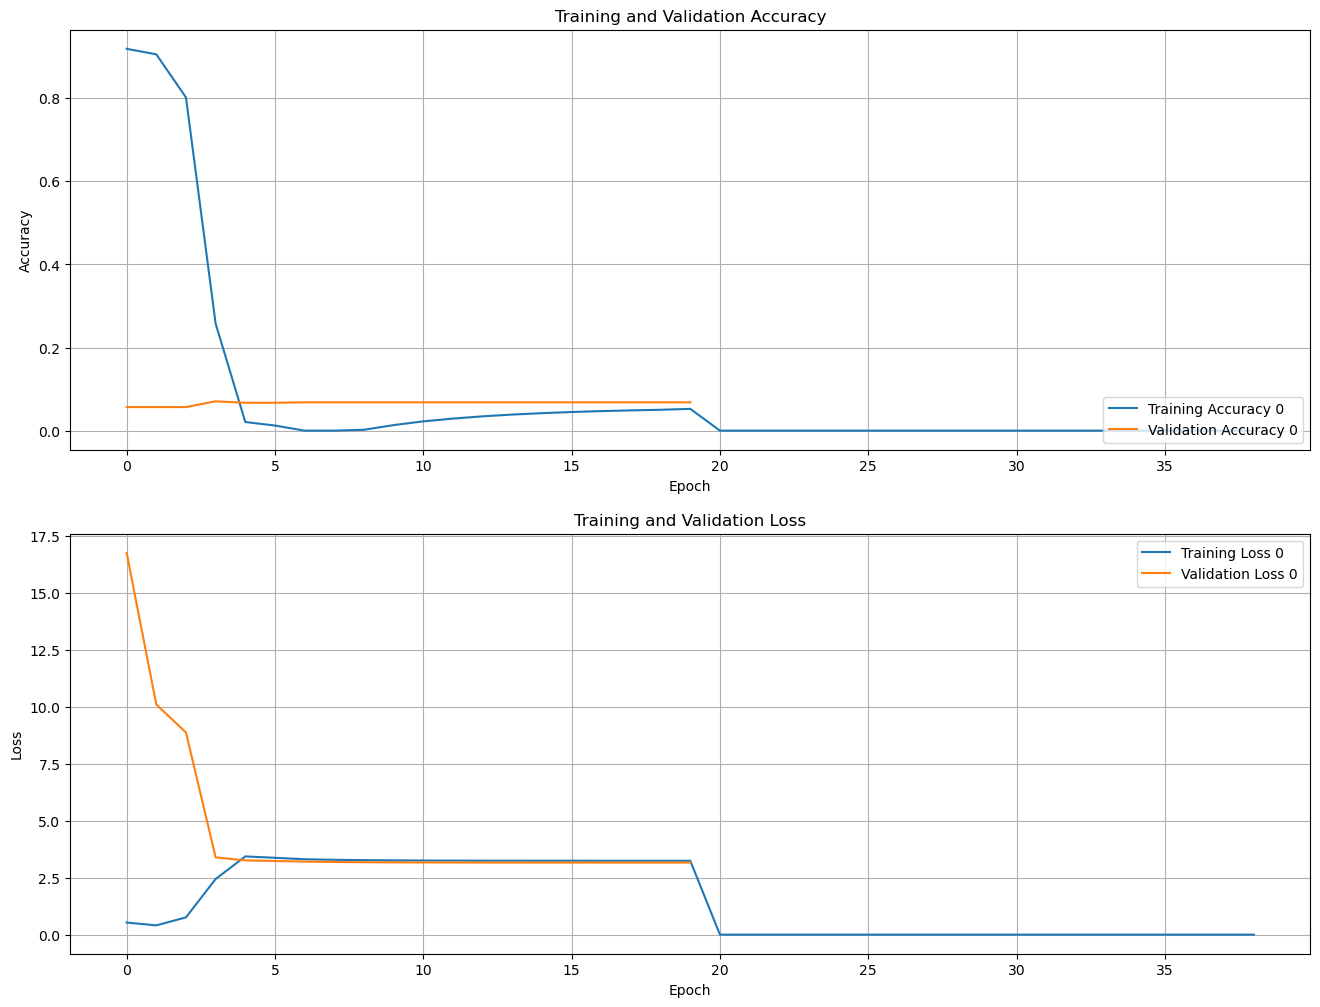

In [22]:
# Optional, plot the accuracy and loss curves of the training and validation sets.
def plot_training():
    
    epochs_range = range(40)
    plt.figure(figsize=(16, 12))
    
    plt.subplot(2, 1, 1)
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid()
    for i in range(0,2,1):
        try:
            print(i)
            with open('models/training_history_{}.p'.format(i), 'rb') as fp:
                print('models/training_history_{}.p'.format(i))
                m = pickle.load(fp)[0]
                print('Training Accuracy {} try?'.format(i))
                acc = m['accuracy'] + ([0] * (epochs_range[-1] - len(m['accuracy'])))
                val_acc = m['val_accuracy'] + ([float('nan')] * (epochs_range[-1] - len(m['val_accuracy'])))
                
                print('Training Accuracy {}'.format(i))
                plt.plot(epochs_range[:-1], acc, label='Training Accuracy {}'.format(i))
                plt.plot(epochs_range[:-1], val_acc, label='Validation Accuracy {}'.format(i))
    
        except Exception as e:
            pass
        
    plt.legend(loc='lower right')

        
    plt.subplot(2, 1, 2)
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    for i in range(0,2,1):
        try:
            with open('models/training_history_{}.p'.format(i), 'rb') as fp:
                m = pickle.load(fp)[0]
                loss = m['loss'] + ([0] * (epochs_range[-1] - len(m['loss'])))
                val_loss = m['val_loss']
                val_loss += ([float('nan')] * (epochs_range[-1] - len(m['val_loss'])))
                
                plt.plot(epochs_range[:-1], loss, label='Training Loss {}'.format(i))
                plt.plot(epochs_range[:-1], val_loss, label='Validation Loss {}'.format(i))
    
        except Exception as e:
            pass
    
    plt.legend(loc='upper right')
    plt.show()

    
plot_training()


In [6]:
db = NABat_DB()
# Get available information for species.
species = db.query('select * from species;')

# Get the index of the species in the model output from the species code.
def get_species_index(species_code):
    for i, s in enumerate(species):
        if s.species_code == species_code:
            return i


# Insert a set of predictions into the database.
def insert(data):
    db.conn.executemany(
        "insert into prediction (model_name, pulse_id, confidence, species_id) values (?,?,?,?);", data)


# Given a species code, return a numeric id.
def get_manual_id(species_code):
    for s in species:
        if s.species_code == species_code:
            return s.id


In [9]:
# Point to a directory of species codes containing .wav files.
directory = '../Downloads/data/wav'
sample_classes = ds.initialize_available_classes(ds.get_sample_classes(directory))
sample_classes

['ANPA',
 'COTO',
 'EPFU',
 'EUPE',
 'IDPH',
 'LABL',
 'LABO',
 'LACI',
 'LAIN',
 'LANO',
 'LASE',
 'MYAU',
 'MYCA',
 'MYCI',
 'MYEV',
 'MYGR',
 'MYLE',
 'MYLU',
 'MYSE',
 'MYSO',
 'MYTH',
 'MYVO',
 'MYYU',
 'NOISE',
 'NYHU',
 'NYMA',
 'PAHE',
 'PESU',
 'TABR']


['ANPA',
 'COTO',
 'EPFU',
 'EUPE',
 'IDPH',
 'LABL',
 'LABO',
 'LACI',
 'LAIN',
 'LANO',
 'LASE',
 'MYAU',
 'MYCA',
 'MYCI',
 'MYEV',
 'MYGR',
 'MYLE',
 'MYLU',
 'MYSE',
 'MYSO',
 'MYTH',
 'MYVO',
 'MYYU',
 'NOISE',
 'NYHU',
 'NYMA',
 'PAHE',
 'PESU',
 'TABR']

In [ ]:
# ds.initialize_available_classes(sample_classes)

[]


In [ ]:
# Define the tuned model.
m = '1'

# Load the tuned model from disk.
model = keras.models.load_model('models/m-{}'.format(m))

# Provide a prediction for each pulse in the test set.
to_predict1 = []
ids = []
data = []
count = 0

for p in ds.test_generator('test'):     
    count += 1
    to_predict1.append(p[0]['input_1'])
    ids.append(p[1])
    
    # Batch the predictions into groupes of 1024.
    if count != 0 and (count % 1024 == 0 ):
        predictions = model.predict(np.array(to_predict1), batch_size=1024)
        for x, prediction in enumerate(predictions):
            for i, c in enumerate(prediction):
                data.append((str(m), ids[x], float(c), get_manual_id(sample_classes[i])))
        
        insert(data)
        to_predict1 = []
        data = []
        ids = []
        
        # Clean up
        gc.collect()
        
        # Report progress.
        print('{}'.format(int(count)))

# Predict the remaining < 1024 predictions not batched in prior step.
predictions = model.predict(np.array(to_predict1),batch_size=len(ids))
for x, prediction in enumerate(predictions):
    for i, c in enumerate(prediction):
        data.append((str(m), ids[x], float(c), get_manual_id(sample_classes[i])))
insert(data)

2023-08-07 19:48:25.389632: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 3s 3s/step
1024
1/1 [==============================] - 2s 2s/step
2048
1/1 [==============================] - 3s 3s/step
3072
1/1 [==============================] - 3s 3s/step
4096
1/1 [==============================] - 3s 3s/step
5120
1/1 [==============================] - 3s 3s/step
6144
1/1 [==============================] - 3s 3s/step
7168
1/1 [==============================] - 3s 3s/step
8192
1/1 [==============================] - 3s 3s/step
9216
1/1 [==============================] - 3s 3s/step
10240
1/1 [==============================] - 3s 3s/step
11264
1/1 [==============================] - 3s 3s/step
12288


KeyboardInterrupt: 

In [ ]:
db_handler.delete_predictions_from_db()